In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pysentani import *
import sentani as sti
survey = find_survey("../data-anonymous")

../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx


In [50]:
survey['access_type'] = survey['village_name'].apply(lambda x: sti.access_map.get(x))

In [68]:
frequency = {'genset_expenditure':'daily'}

multiplier = {'daily':30}

# create new columns with same monthly frequency
for column in frequency.keys():
    # adjust expenditure frequency
    expenditure = survey[column] * multiplier[frequency[column]]
    new_column = column + '_monthly'
    survey[new_column] = expenditure



pd.set_option('max_rows', 200)
survey.groupby(['access_type'])[['genset_expenditure_monthly']].agg(['mean','count'])

genset_expenditure_monthly      
                                          mean count
access_type                                         
PLN_grid                        5950000.000000     3
PLN_microgrid                   1115789.473684    57
community_microgrid             4500000.000000     1
no_access                       1135787.191011   178

In [69]:
#monthly expenditure divided by 960 rp per kWh (.08 USD per kWh * 12000 rp to USD exchange)
def genset_kwh_conversion(df):
    converted = (df['genset_expenditure_monthly']/(960))
    return converted

survey['genset_kWh'] = survey.apply(genset_kwh_conversion, axis=1)

# kWh multiplied by Lawrence Berkely Labratory estimation of 1100 g CO2 per kWh
def CO2_emission(df1):
    converted = df1['genset_kWh']*1100 
    return converted

survey['CO2_g'] = survey.apply(CO2_emission, axis=1)

# Potential Photovoltaic carbon emissions (g CO2 per kWh), (if genset replaced by PV)
def PV_emission(df2):
    converted = df2['genset_kWh']*100
    return converted
survey['PV_emission'] = survey.apply(PV_emission, axis=1)

# CO2 reduction (co2(g) column - PV_emission column)

def CO2_reduction(df3):
    converted = df3['CO2_g']-survey['PV_emission']
    return converted
survey['CO2_reduction'] = survey.apply(CO2_reduction, axis=1)

In [70]:
pd.set_option('max_rows',100)
df = survey.groupby(['access_type',
                'village_name'])[['genset_expenditure_monthly',
                                  'genset_kWh','CO2_g','PV_emission','CO2_reduction']].agg(['mean']).dropna()

In [71]:
df

genset_expenditure_monthly    genset_kWh  \
                                                       mean          mean   
access_type         village_name                                            
PLN_grid            Hobong                  15000000.000000  15625.000000   
                    Khamayakha               1425000.000000   1484.375000   
PLN_microgrid       Ayapo                    1115789.473684   1162.280702   
community_microgrid Atamali                  4500000.000000   4687.500000   
no_access           Abar                     1200000.000000   1250.000000   
                    Ebunfauw                  988888.888889   1030.092593   
                    Kalio                    1150000.000000   1197.916667   
                    Kampung_Baru             1280000.000000   1333.333333   
                    Khageuw                  1050000.000000   1093.750000   
                    Puai                     1419285.714286   1478.422619   
                    Yoboi                     703452.413793    732.762931   
                    Yokiwa                   1143750.000000   1191.406250   

                                            CO2_g     PV_emission  \
                                             mean            mean   
access_type         village_name                                    
PLN_grid            Hobong        17187500.000000  1562500.000000   
                    Khamayakha     1632812.500000   148437.500000   
PLN_microgrid       Ayapo          1278508.771930   116228.070175   
community_microgrid Atamali        5156250.000000   468750.000000   
no_access           Abar           1375000.000000   125000.000000   
                    Ebunfauw       1133101.851852   103009.259259   
                    Kalio          1317708.333333   119791.666667   
                    Kampung_Baru   1466666.666667   133333.333333   
                    Khageuw        1203125.000000   109375.000000   
                    Puai           1626264.880952   147842.261905   
                    Yoboi           806039.224138    73276.293103   
                    Yokiwa         1310546.875000   119140.625000   

                                    CO2_reduction  
                                             mean  
access_type         village_name                   
PLN_grid            Hobong        17031250.000000  
                    Khamayakha     1476562.500000  
PLN_microgrid       Ayapo          1122258.771930  
community_microgrid Atamali        5000000.000000  
no_access           Abar           1218750.000000  
                    Ebunfauw        976851.851852  
                    Kalio          1161458.333333  
                    Kampung_Baru   1310416.666667  
                    Khageuw        1046875.000000  
                    Puai           1470014.880952  
                    Yoboi           649789.224138  
                    Yokiwa         1154296.875000

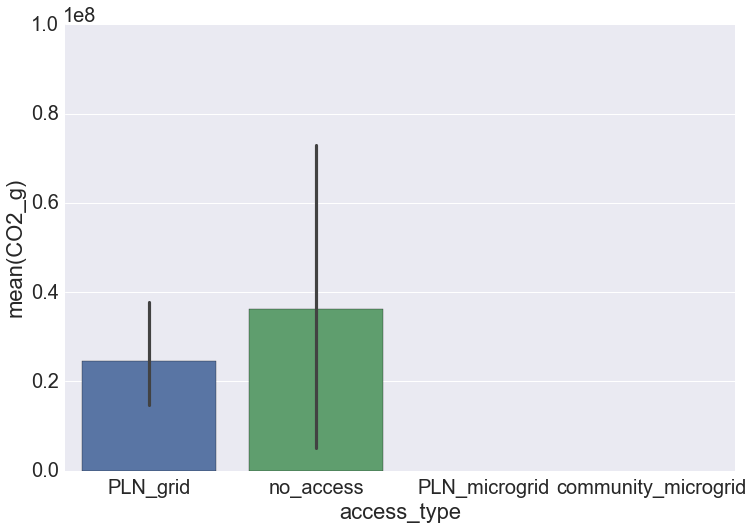

In [72]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x="access_type", y='CO2_g', data=df4)

plt.ylim(0,1e8)
locs, labels = plt.xticks()

###This graph represents g/kWh of CO2 emmisions currently produced by diesel generators in Lake Sentani.

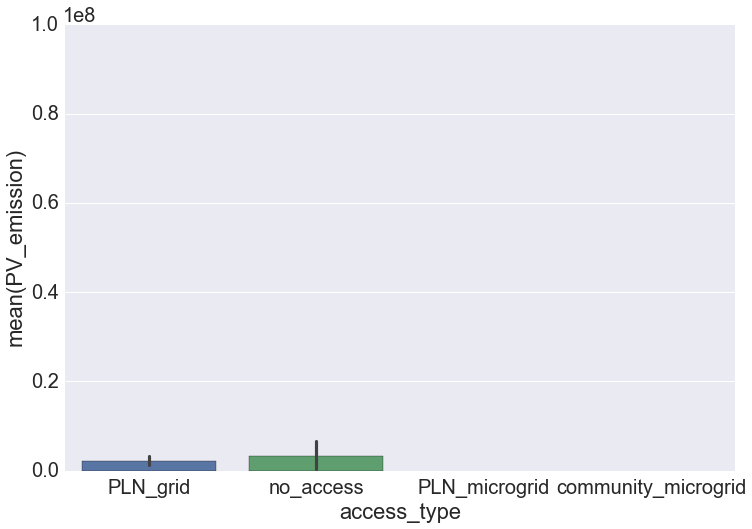

In [73]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x="access_type", y='PV_emission', data=df4)


plt.ylim(0,1e8)
locs, labels = plt.xticks()
## This graph represents the total g CO2/kWh if generators are replaced with Photovoltaic Microgrids.

In [66]:
pd.set_option('max_rows',100)
df = survey.groupby(['access_type'
                ])[['genset_expenditure_monthly',
                                  'genset_kWh','CO2_g','PV_emission','CO2_reduction']].agg(['mean']).dropna()

In [67]:
df

,genset_expenditure_monthly,genset_kWh,CO2_g,PV_emission,CO2_reduction
,mean,mean,mean,mean,mean
access_type,,,,,
PLN_grid,5950000.000000,6197.916667,6817708.333333,619791.666667,6661458.333333
PLN_microgrid,1115789.473684,1162.280702,1278508.771930,116228.070175,1122258.771930
community_microgrid,4500000.000000,4687.500000,5156250.000000,468750.000000,5000000.000000
no_access,1135787.191011,1183.111657,1301422.823034,118311.165730,1145172.823034
